In [1]:
import numpy as np
from boxvectors import directions as directions
import Initial_Parameters as ip
from md import System
from md import md
from distribution import maxwellboltzmann
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.special import erfc
from scipy.constants import epsilon_0
%matplotlib inline

In [2]:
Symbols = ip.Symbols
Coefficients = ip.Coefficients
Charges = ip.Charges
N = ip.N*np.sum(Coefficients)
L = ip.L
T = ip.T
dt = ip.dt
p_rea = ip.p_rea
n_boxes_short_range = ip.n_boxes_short_range
p_error = ip.p_error
Sys= System(Symbols, Coefficients, Charges, N/2)
Labels = Sys.get_Labels()
Sigma, Epsilon = Sys.get_LJ_parameter()
r_cut_LJ = ip.r_cut_LJ
r_switch = ip.r_switch
m = Labels[:,0]

In [3]:
def get_random_starting_Positions(N,L):
    Positions = np.zeros((N,3))
    Positions[:,0] = np.linspace(0,L[0],N, endpoint = False)
    Positions[:,1] = np.linspace(0,L[1],N, endpoint = False)
    Positions[:,2] = np.linspace(0,L[2],N, endpoint = False)
    np.random.shuffle(Positions[:,0])
    np.random.shuffle(Positions[:,1])
    np.random.shuffle(Positions[:,2])
    return Positions
Positions = get_random_starting_Positions(N,L)
Velocities = maxwellboltzmann().sample_distribution(N,m,T)
Forces = np.zeros((N,3))
# R = np.linalg.norm(Positions,axis=1)

In [4]:
G = ((directions(2).get_directions()))
G = G +2
Positions = np.zeros(G.shape)
Positions[:G[::2].shape[0]]= G[::2]
Positions[G[::2].shape[0]:] = G[1::2]
Positions = np.delete(Positions, np.where(np.max(Positions, axis = 1)==4),axis = 0)
Positions = (Positions*564e-12)+282e-12
Positions *=1e10
R = np.linalg.norm(Positions,axis=1)


In [5]:
d=1.1
L*=d
Positions*=d
r_cut_LJ*=d
r_switch *=d

In [6]:
MD = md(
    Positions, 
    Labels, 
    Velocities,
    Forces, 
    L, 
    T, 
    Sigma, 
    Epsilon, 
    r_switch,
    r_cut_LJ,
    n_boxes_short_range,
    dt, 
    p_rea,
    p_error,
    Symbols)

In [7]:
MD.forces = MD.get_forces()

In [8]:
# print MD.get_energy()
# print MD.get_potential()
# print MD.forces

In [9]:
import os
import time
cwd = os.getcwd()
cwd

'C:\\Users\\Marco\\Documents\\GitHub\\compsci-proj-md-master\\md'

In [10]:
start = time.time()
MD.minmimize_Energy(N_steps = 500, threshold=1e-2, Energy_save=1,  Frame_save=1, max_displacement= 1e-3, path=cwd)
ende = time.time()
print("\n")
print(ende-start)

100.0% of steps completedMaximum Number of Steps reached


578.134000063


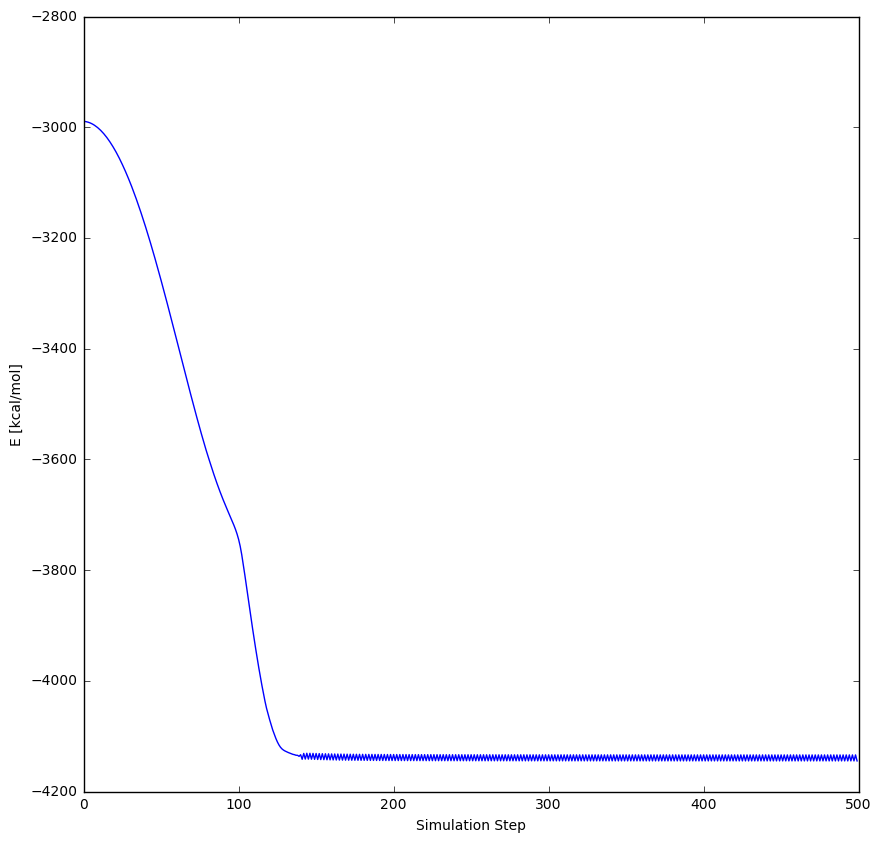

In [24]:
Energy = np.loadtxt('Energies_minimization')
plt.figure(figsize=(10,10))
plt.plot(Energy)
plt.xlabel('Simulation Step')
plt.ylabel('E [kcal/mol]')

In [34]:
MD.T = 100
MD.velocities = maxwellboltzmann().sample_distribution(N,m,MD.T)

In [ ]:
start = time.time()
MD.get_traj(N_steps=500, Energy_save=1, Temperature_save=1, Frame_save=1, path = cwd)
ende = time.time()
print("\n")
print(ende-start)

1.0% of steps completed

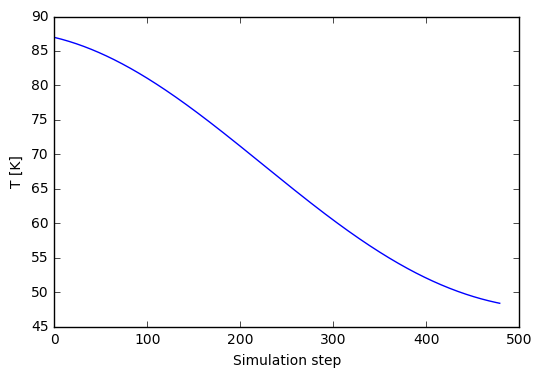

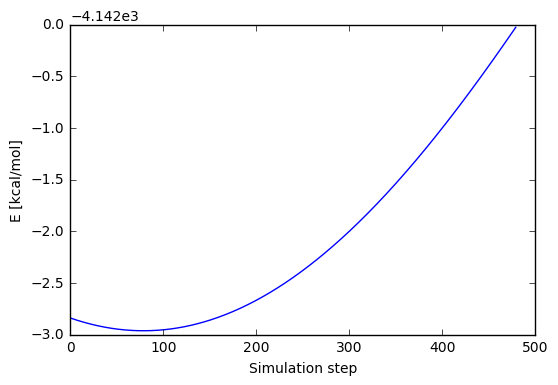

In [33]:
plt.plot(np.loadtxt('Temperature')*1.38e-23/0.0001987191)
plt.xlabel('Simulation step')
plt.ylabel('T [K]')
plt.figure()
plt.plot(np.loadtxt('Energies'))
plt.xlabel('Simulation step')
plt.ylabel('E [kcal/mol]')

In [13]:
K = directions(MD.n_boxes_short_range).get_directions()
K[:,0] *=L[0]
K[:,1] *=L[1]
K[:,2] *=L[2]

N = np.size(Positions[:,0])
Force_short_range = np.zeros((N,3))
k = np.size(K[:,0])
charges_pre_delete = np.zeros((N,3))
charges_pre_delete[:,0]=Labels[:,1]  
charges_pre_delete[:,1]=Labels[:,1] 
charges_pre_delete[:,2]=Labels[:,1] 
for i in np.arange(N):

    dists_single_cell_pre_delete = Positions[i,:]-Positions
    dists_single_cell = np.delete(dists_single_cell_pre_delete,i,0)
    charges = np.delete(charges_pre_delete,i,0)
    #This Skript paralellizes the sum over j and executes the sum over vectors n within the loop
    for j in np.arange(k):
        dists = dists_single_cell+K[j]

        norm_dists = np.linalg.norm(dists, axis = 1)
        norm_dists_right_size = np.outer(norm_dists, np.ones(3))

        Force_short_range[i,:] += np.sum(charges*dists/norm_dists_right_size**2 
        *( erfc( norm_dists_right_size/np.sqrt(2)/MD.std )/norm_dists_right_size 
        + np.sqrt(2.0/np.pi)/MD.std*np.exp(-norm_dists_right_size**2/(2*MD.std**2) )) ,0)

#Getting the Pre-factor right        
Force_short_range = Force_short_range* charges_pre_delete /(8*np.pi*MD.coulomb.epsilon0)

SyntaxError: 'return' outside function (<ipython-input-13-8584addd36cc>, line 31)